# Music generation

In [40]:
# !pip install fluidsynth  # corrupt

In [41]:
import numpy as np
import pandas as pd
import glob
import pathlib
import collections
import datetime
# import fluidsynth # corrupt
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

## Process the MIDI files

In [42]:
seed = 420
tf.random.set_seed(seed)
np.random.seed(seed)
# Sampling rate for audio playback
_SAMPLING_RATE = 16000
data_dir = pathlib.Path('../data')
filenames = glob.glob(str('**/*/*.mid*'),root_dir=data_dir)
print('Number of all MIDI files:', len(filenames)) # 1646, 18243, 18525

Number of all MIDI files: 364


In [112]:
# ok  = open('ok.txt', 'wt', encoding="utf-8")
# bad = open('bad.txt', 'wt', encoding="utf-8")
# good= open('good.csv', 'wt', encoding="utf-8")

s=0
for fn in filenames:
    s+=1
    rel_path = str(data_dir)+'\\'+fn
    # print(f'{s:6d}, {fn}')
    # try:
        # pm = pretty_midi.PrettyMIDI(rel_path)

    # except:
        # log and delete all the invalid MIDI flies
        # bad.write(f'{s:6d}, {fn}\n')
        # pathlib.Path(rel_path).unlink(missing_ok=True)
        # continue

    # if len(pm.instruments)==1:
    #     s+=1
        # print(f'good {s:6d}\t{fn}')
    # good.write(f'{s:6d}, {rel_path}\n')
    # else:

        # i=0
        # print(f'ok {s:6d}\t{fn}')
        # ok.write(f'ok {s:6d}, {rel_path}\n')
        # for inst in pm.instruments:
        #     i+=1
        #     ok.write(f'\t{i:2d}. {inst.program:3d}, {pretty_midi.program_to_instrument_name(inst.program)}\n')
print('Number of 1-instrument MIDI files:', s) # 1656 = 374 pop + 1282 maestro

# good.close()
# bad.close()
# ok.close()

faves = (218,220,229,230,269,270,271,331,333,334,335,336,342)
for i in faves:
	print(f'{i}\t{filenames[i]}')

Number of 1-instrument MIDI files: 364
218	clean_midi\Led Zeppelin\Stairway To Heaven.7.mid
220	clean_midi\Lennon John\Imagine.2.mid
229	clean_midi\Metallica\(Anesthesia)-Pulling Teeth.1.mid
230	clean_midi\Metallica\Die, Die My Darling.mid
269	clean_midi\Queen\Procession.mid
270	clean_midi\Ray Charles\Georgia.mid
271	clean_midi\Roberta Flack\Killing Me Softly.mid
331	clean_midi\The Beatles\Eight Days A Week.4.mid
333	clean_midi\The Beatles\I'm Gonna Sit Right Down and Cry (Over You).mid
334	clean_midi\The Beatles\In My Life.1.mid
335	clean_midi\The Beatles\In My Life.5.mid
336	clean_midi\The Beatles\Sgt. Pepper Inner Groove.mid
342	clean_midi\U2\The Electric Co..1.mid


## Extract notes

Three variables that represent a note are: `pitch`, `step` and `duration`.
The `pitch` is the perceptual quality of the sound as a MIDI note number.
The `step` is the time elapsed from the previous note or start of the track.
The `duration` is how long the note will be playing in seconds and `duration` = note end - start times.
To simplify the sampling process I will extract one-instrument MIDI files to a notes dataframe.

In [113]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    # 1st & only instrument
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    _start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - _start)
        notes['duration'].append(end - start)
        _start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [114]:
def plot_track(notes: pd.DataFrame, name: Optional[str] = None):
    if name:
        title = f'{name}'
    else:
        title = f'The whole enchilada'
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="g", marker="o")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

clean_midi\Led Zeppelin\Stairway To Heaven.7.mid
clean_midi\Lennon John\Imagine.2.mid
clean_midi\Metallica\(Anesthesia)-Pulling Teeth.1.mid
clean_midi\Metallica\Die, Die My Darling.mid
clean_midi\Queen\Procession.mid
clean_midi\Ray Charles\Georgia.mid
clean_midi\Roberta Flack\Killing Me Softly.mid
clean_midi\The Beatles\Eight Days A Week.4.mid
clean_midi\The Beatles\I'm Gonna Sit Right Down and Cry (Over You).mid
clean_midi\The Beatles\In My Life.1.mid
clean_midi\The Beatles\In My Life.5.mid
clean_midi\The Beatles\Sgt. Pepper Inner Groove.mid
clean_midi\U2\The Electric Co..1.mid
17228 number of notes parsed from 13 tracks.


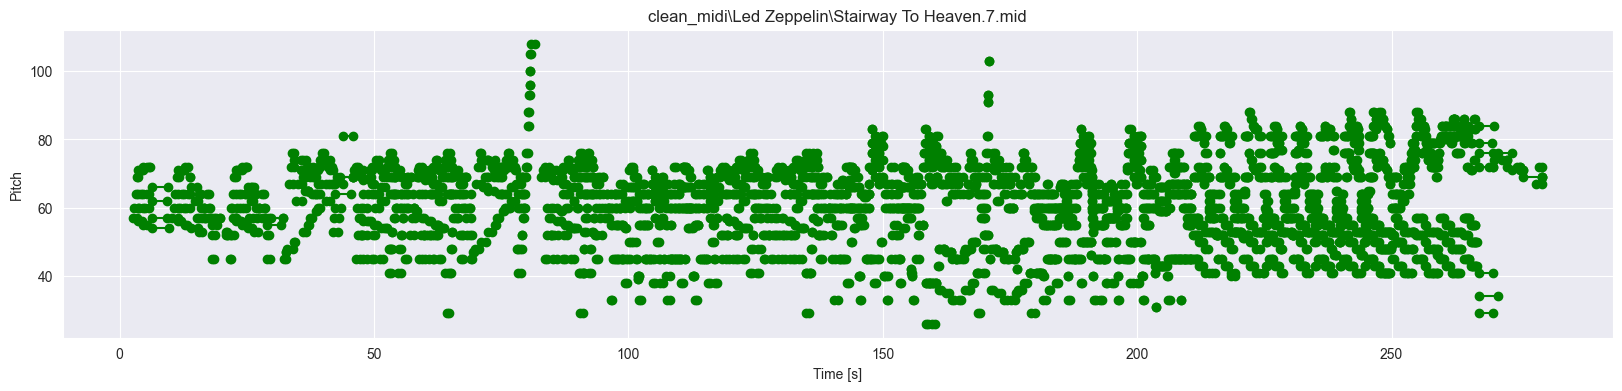

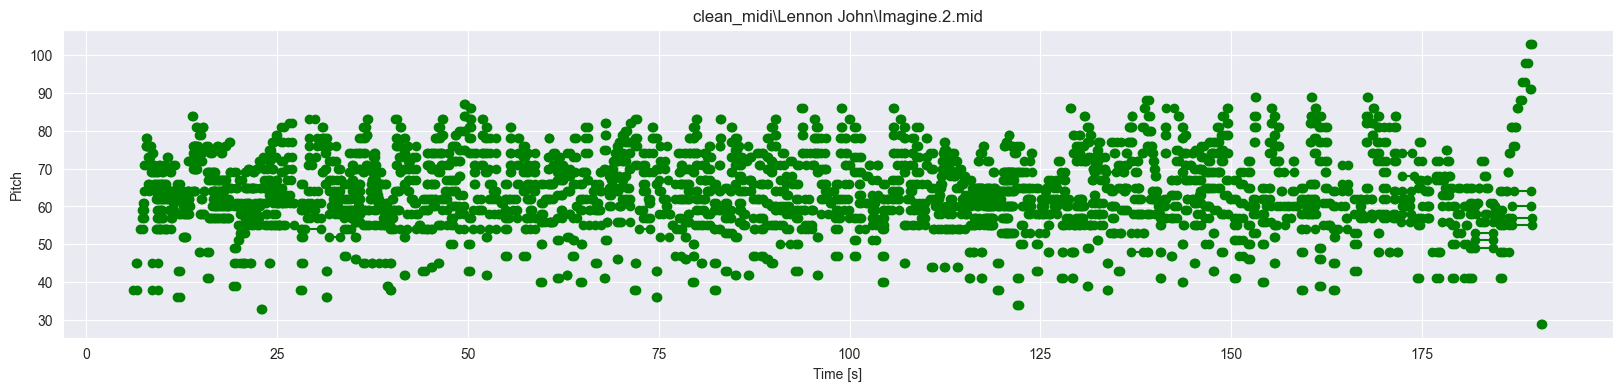

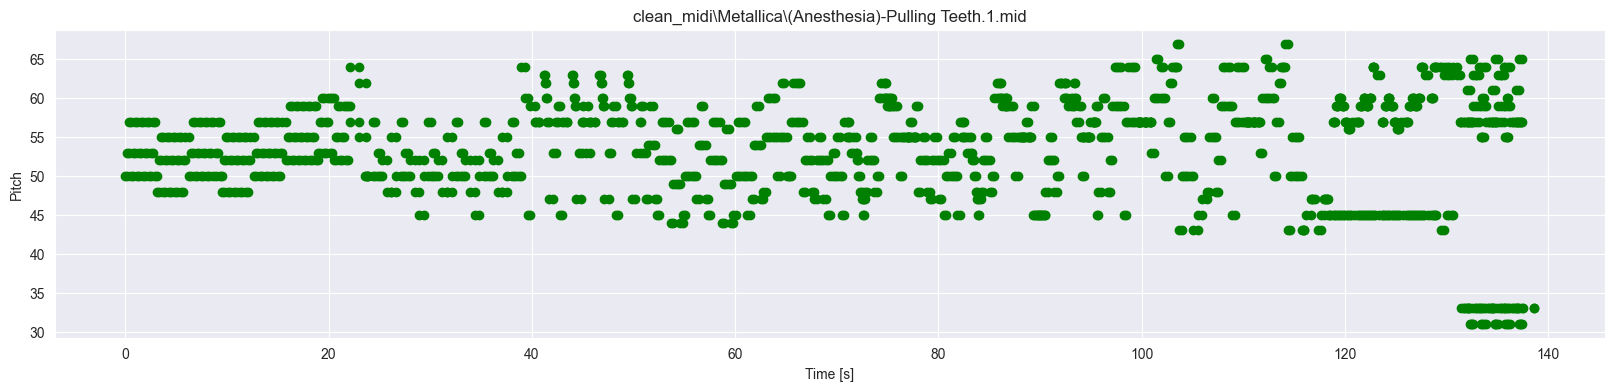

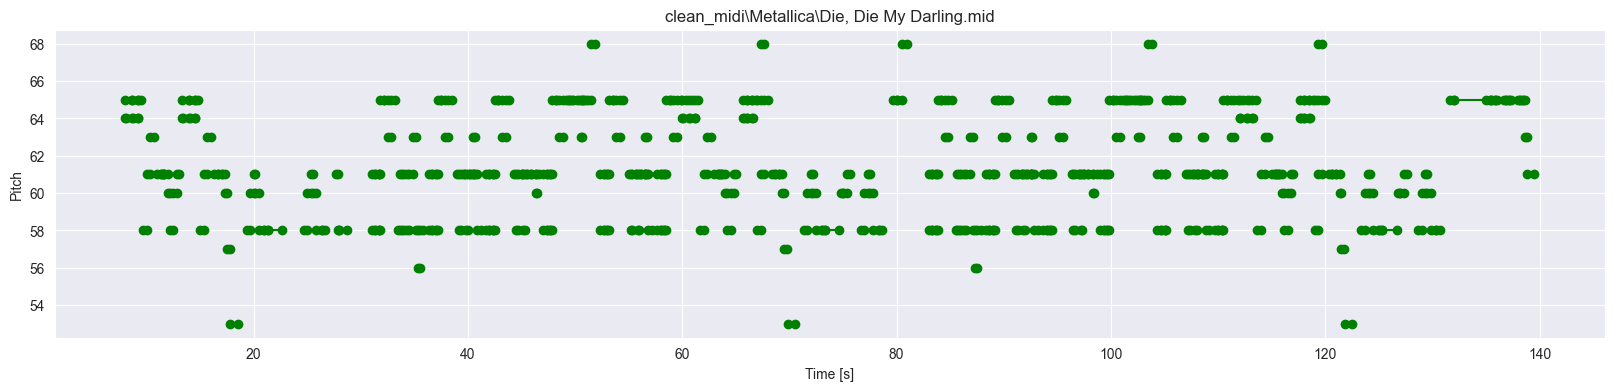

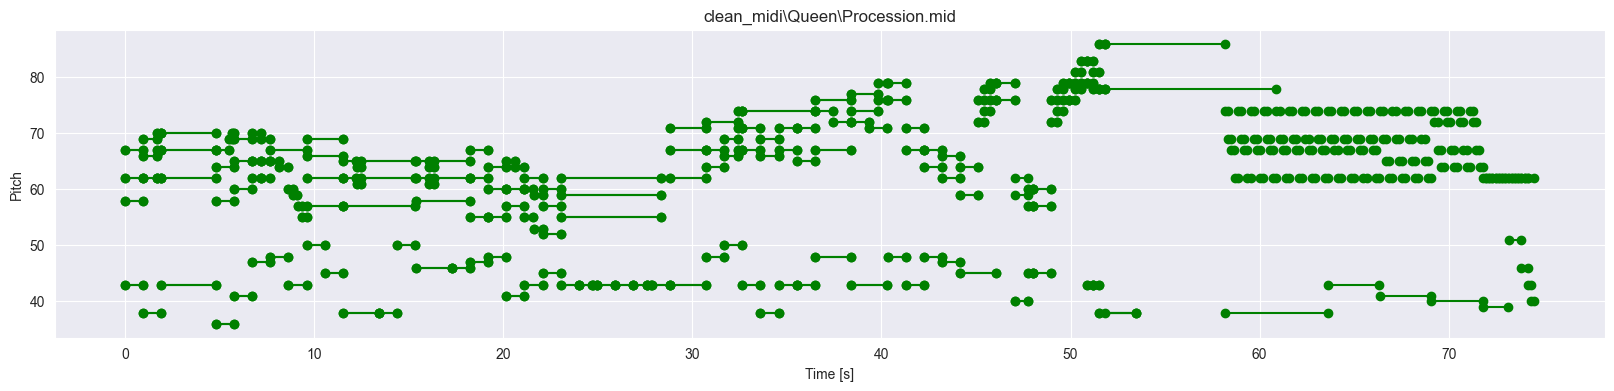

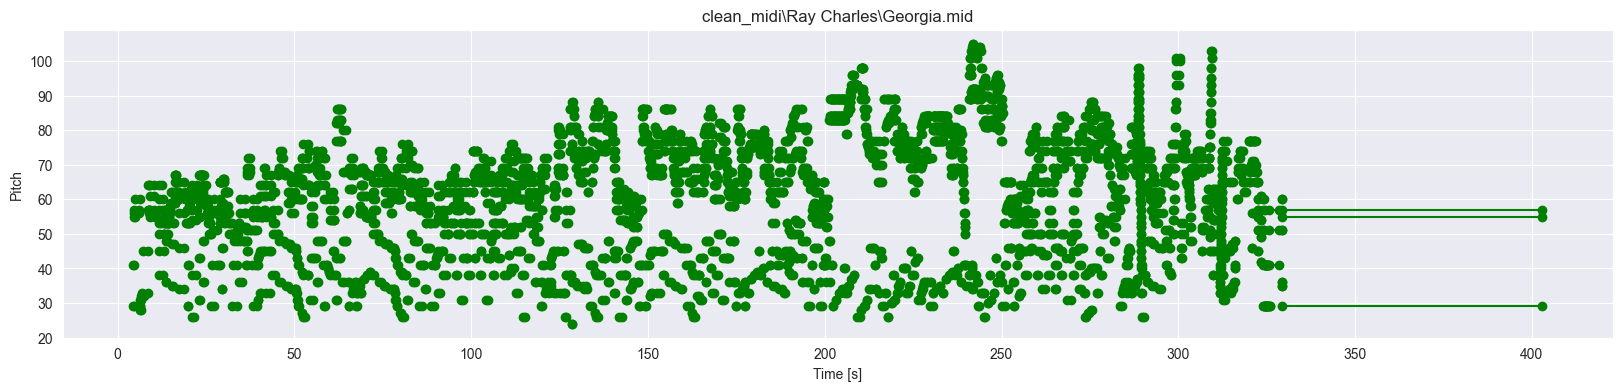

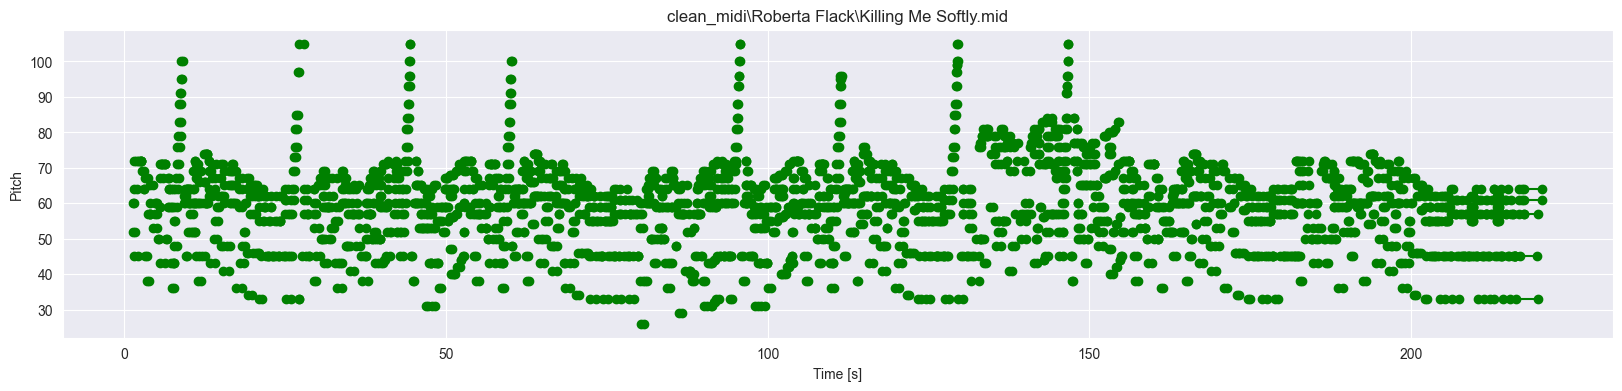

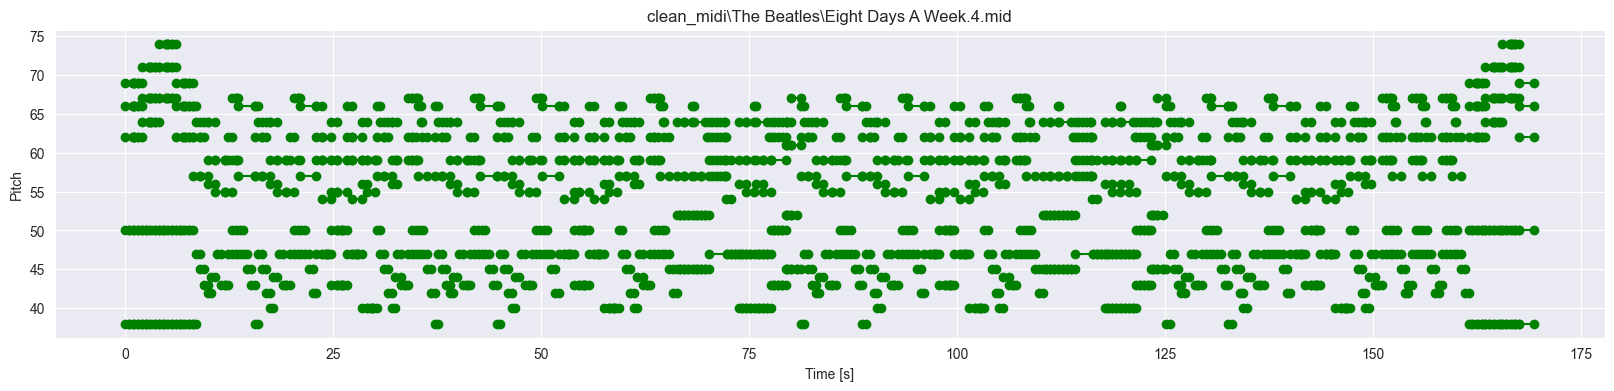

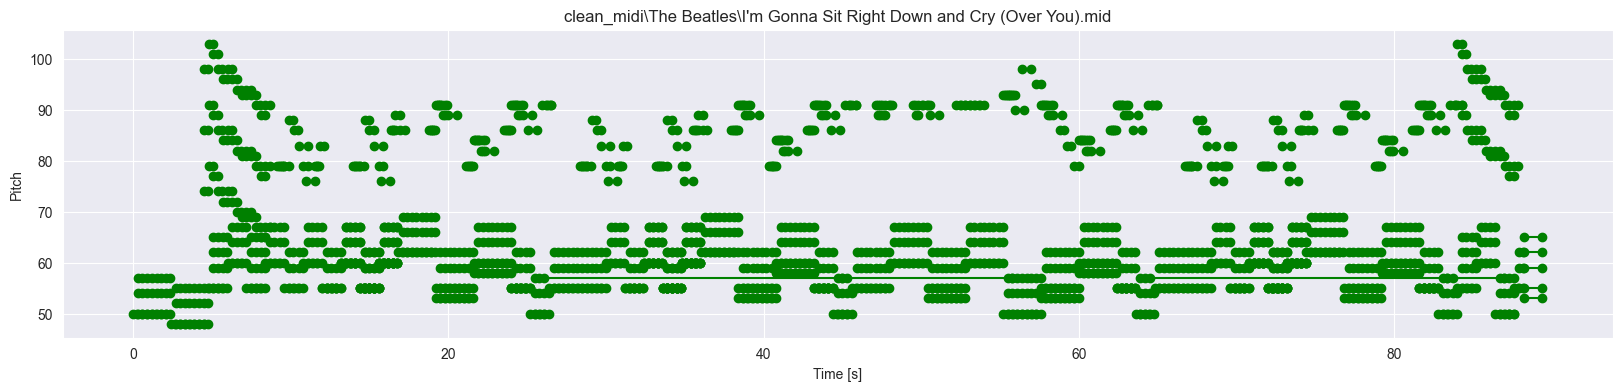

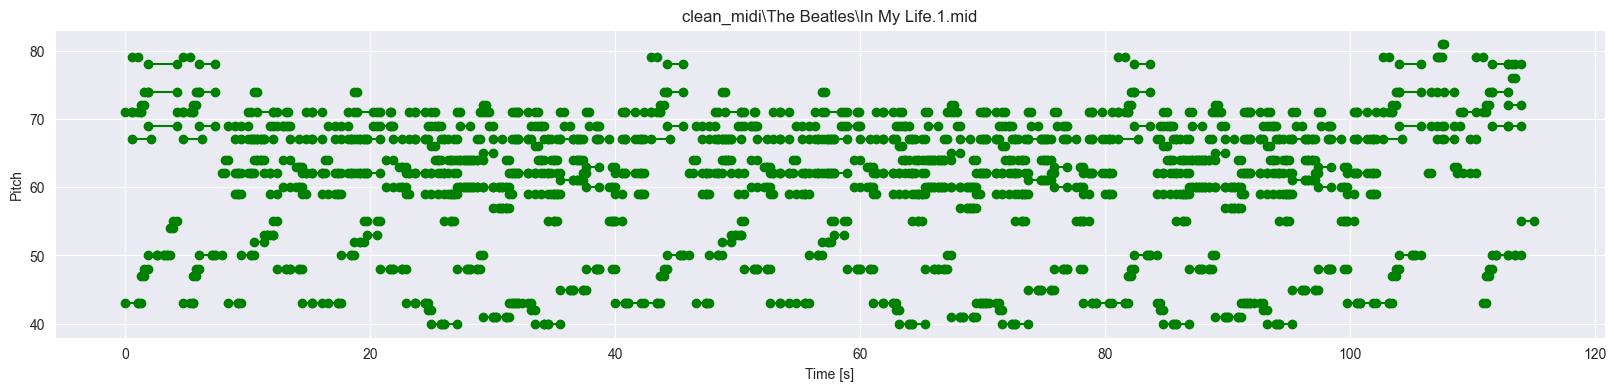

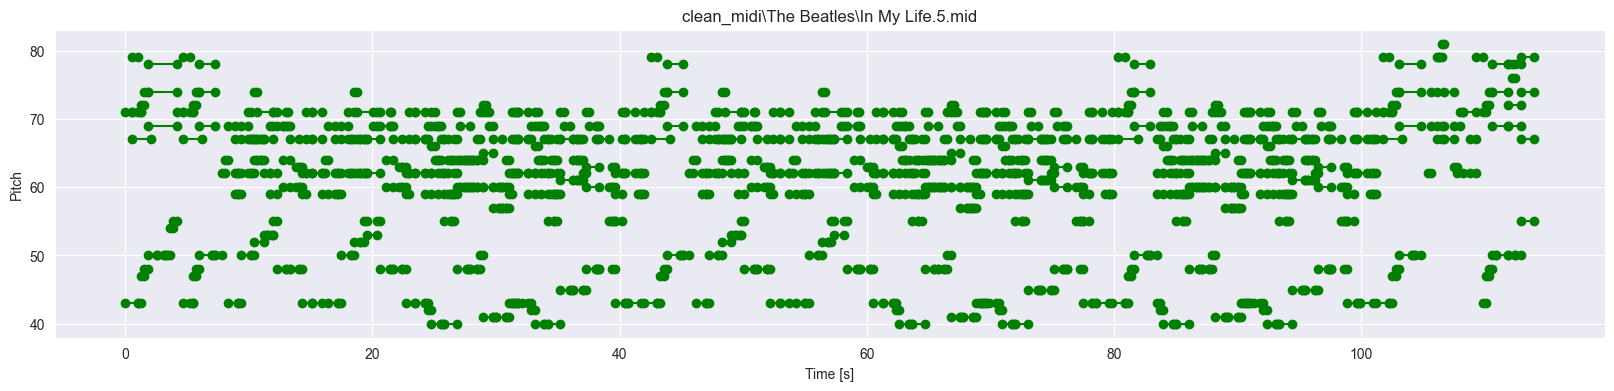

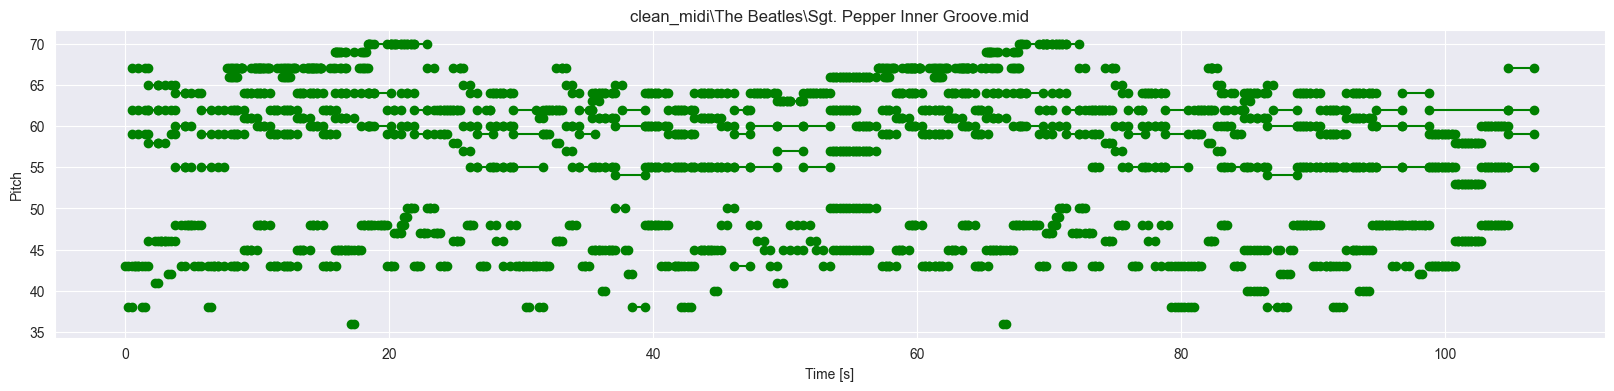

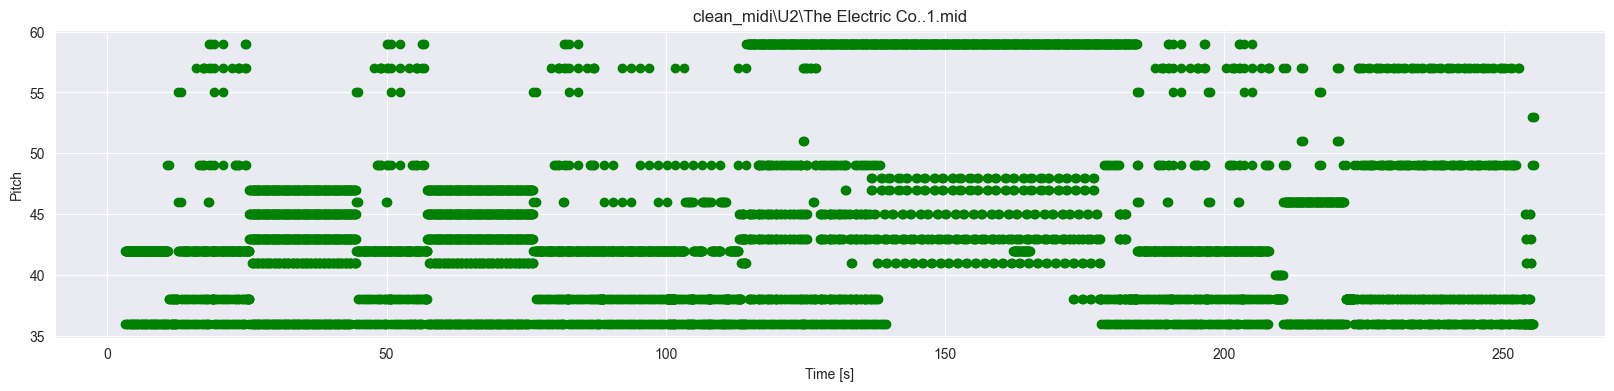

In [115]:
all_notes = []
for i in faves:
    print(filenames[i])
    file = str(data_dir)+'\\'+filenames[i]
    notes = midi_to_notes(file)
    plot_track(notes, filenames[i])
    all_notes.append(notes)
all_notes = pd.concat(all_notes)
print(f'{len(all_notes)} number of notes parsed from {len(faves)} tracks.')

To visualize the musical piece the utility ```plot_track``` function plots the notes ```pitch``` values, ```start``` and ```end``` (as I showed in ```midi_to_notes``` function above the ```step``` and ```duration``` are derived from those) across the length of track(s). The individual tracks plots look informative, however plot of the notes of all 12 tracks, superimposed, looks a bit gibberish.

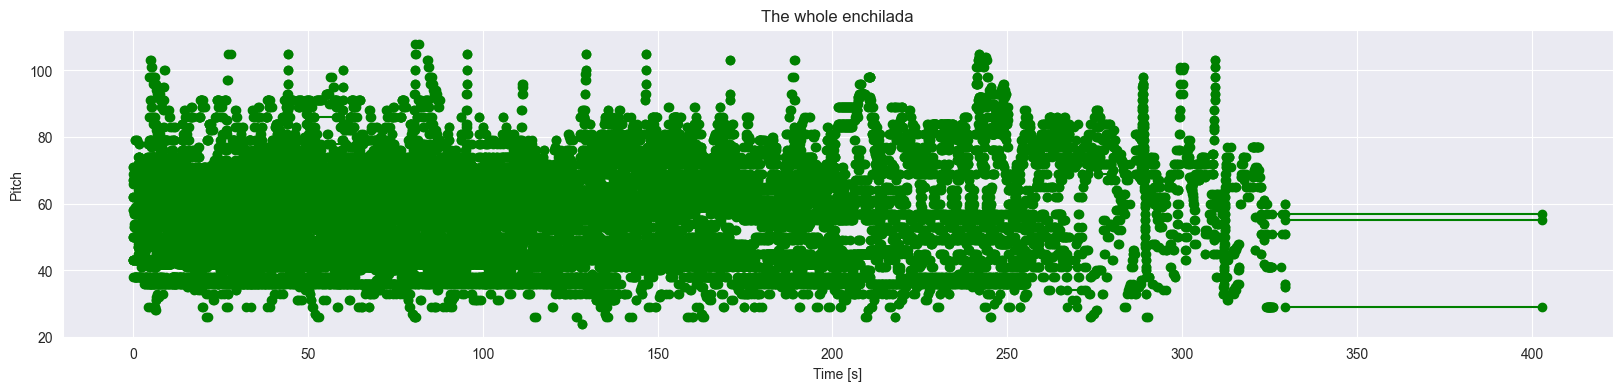

In [116]:
plot_track(all_notes)

Check the distribution of each note variable.

In [117]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 3, 1)
    sns.histplot(notes, x="pitch", bins=20, color='green')

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21), color='green')

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21), color='green')

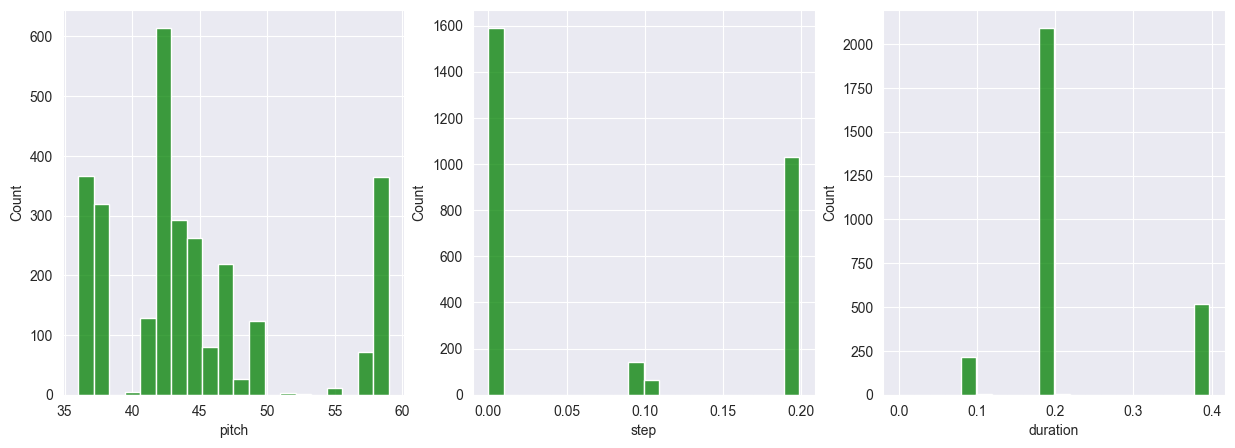

In [118]:
plot_distributions(notes)

## Create a MIDI file with different instruments

Let's generate a MIDI file by changing the instrument, still a 1-imstrument MIDI though.

In [121]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

    _start = 0
    for i, note in notes.iterrows():
        start = float(_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        _start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [122]:
# _instruments=['Bright Acoustic Piano','Electric Guitar (jazz)','Electric Bass (finger)','Cello','Sitar','Bagpipe','Voice Oohs']
# for i in _instruments:
#     fn = f'{data_dir}\\{i}\\{filenames[8426]}' # Imagine
#     # touch data_dir\instrument\path\to\song.midi
#     pathlib.Path(fn).mkdir()
#     pathlib.Path(fn).touch(exist_ok=True)
#     pm = notes_to_midi(notes, out_file=fn, instrument_name=i)

## Create the training dataset

A training `tf.data.Dataset` is created from the parsed MIDI files notes. Let's start with the 12 files, and see how it goes.

In [123]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

Let's train the model on batches of sequences of notes. Each example will consist of a sequence of notes as the input features, and the next note as the label. This way, the model will be trained to predict the next note in a sequence. There is a handy function [tf.data.Dataset.window(`seq_length`)](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#window) to create the features and labels.

In [124]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    note_range = 128,
) -> tf.data.Dataset:
    """Returns TF Dataset of sequence and label examples."""
    seq_length = seq_length+1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)
  
    # Normalize note pitch
    def scale_pitch(x):
        x = x/[note_range, 1.0, 1.0]
        return x

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [125]:
print(f'pitch -- note')
for i in range(12,132,1):
    print(f'{i:5d} -- {pretty_midi.note_number_to_name(i)}')

pitch -- note
   12 -- C0
   13 -- C#0
   14 -- D0
   15 -- D#0
   16 -- E0
   17 -- F0
   18 -- F#0
   19 -- G0
   20 -- G#0
   21 -- A0
   22 -- A#0
   23 -- B0
   24 -- C1
   25 -- C#1
   26 -- D1
   27 -- D#1
   28 -- E1
   29 -- F1
   30 -- F#1
   31 -- G1
   32 -- G#1
   33 -- A1
   34 -- A#1
   35 -- B1
   36 -- C2
   37 -- C#2
   38 -- D2
   39 -- D#2
   40 -- E2
   41 -- F2
   42 -- F#2
   43 -- G2
   44 -- G#2
   45 -- A2
   46 -- A#2
   47 -- B2
   48 -- C3
   49 -- C#3
   50 -- D3
   51 -- D#3
   52 -- E3
   53 -- F3
   54 -- F#3
   55 -- G3
   56 -- G#3
   57 -- A3
   58 -- A#3
   59 -- B3
   60 -- C4
   61 -- C#4
   62 -- D4
   63 -- D#4
   64 -- E4
   65 -- F4
   66 -- F#4
   67 -- G4
   68 -- G#4
   69 -- A4
   70 -- A#4
   71 -- B4
   72 -- C5
   73 -- C#5
   74 -- D5
   75 -- D#5
   76 -- E5
   77 -- F5
   78 -- F#5
   79 -- G5
   80 -- G#5
   81 -- A5
   82 -- A#5
   83 -- B5
   84 -- C6
   85 -- C#6
   86 -- D6
   87 -- D#6
   88 -- E6
   89 -- F6
   90 -- F#6
   91

I set the sequence length `seq_length` to 100, and will experiment with different lengths (e.g. 50, 150, 200) to see which one works best for the data, or use [hyperparameter tuning](https://www.tensorflow.org/tutorials/keras/keras_tuner).

I set the range of MIDI notes `note_range` to 128 representing the pitches supported by `pretty_midi`.

In [126]:
seq_length = 100
note_range = 128
seq_ds = create_sequences(notes_ds, seq_length, note_range)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

The shape of the dataset is ```(100,3)```, meaning that the model has 100 notes by `pitch`,`step`,`duration` as input.
The `take(1)` method will learn to predict the following 1 note as output.

In [127]:
for seq, target in seq_ds.take(1):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 10):', seq[0: 10])
    print()
    print(f'target pitch: {target["pitch"]:1.0f}, step: {target["step"]:1.4f}, duration: {target["duration"]:1.4f}')

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.4453125  0.         0.825     ]
 [0.46875    0.25833333 0.65      ]
 [0.5        0.2375     0.4125    ]
 [0.5390625  0.225      0.19166667]
 [0.5546875  0.24166667 0.54166667]
 [0.4375     0.00416667 0.85      ]
 [0.46875    0.27916667 0.63333333]
 [0.5        0.27916667 0.40833333]
 [0.5546875  0.24583333 0.23333333]
 [0.5625     0.2875     0.62916667]], shape=(10, 3), dtype=float64)

target pitch: 71, step: 0.4667, duration: 0.2542


Batch the examples, and configure the dataset for performance.

In [128]:
batch_size = 64
n_notes = len(notes)
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE)) # other options?

In [129]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create the model

The model will have three outputs, one for each note variable. For `step` and `duration`, I will use a custom loss `mse_with_positive_pressure()` function based on MSE that encourages the model to output non-negative values.

In [130]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [131]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(note_range)(inputs)

outputs = {
  'pitch': 	  tf.keras.layers.Dense(note_range, name='pitch')(x),
  'step': 	  tf.keras.layers.Dense(1,          name='step')(x),
  'duration': tf.keras.layers.Dense(1,          name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch':    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      'step': 	  mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 100, 3)]             0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 128)                  67584     ['input_3[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_2[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_2[0][0]']              
                                                                                            

In [132]:
losses = model.evaluate(train_ds, return_dict=True)
losses
# Need NVIDIA GPU box, the Intel GPU causes this:
# InvalidArgumentError: Graph execution error
# No OpKernel was registered to support Op 'CudnnRNN' used by {{node CudnnRNN}} with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
# Registered devices: [CPU, GPU]
# Registered kernels:
#   <no registered kernels>
#
# 	 [[CudnnRNN]]
# 	 [[model/lstm/PartitionedCall]] [Op:__inference_test_function_1969]

267/267 [==============================] - 19s 66ms/step - loss: 6.4431 - duration_loss: 1.1952 - pitch_loss: 4.8455 - step_loss: 0.4025


{'loss': 6.443146228790283,
 'duration_loss': 1.1951658725738525,
 'pitch_loss': 4.845514297485352,
 'step_loss': 0.4024624228477478}

While testing the `model.evaluate` function, it is clear that the `pitch` loss is significantly greater than the `step` and `duration` losses, because `loss` is the total loss computed by summing the `pitch`, `step`, `duration` losses and is dominated by the `pitch` loss. One way balance this is to use the `loss_weights` argument to compile:

In [133]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch':   0.07,
        'step':    1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

The `loss` then becomes the weighted sum of the individual losses with `pitch` influence reduced.

In [134]:
%%time
model.evaluate(train_ds, return_dict=True)

267/267 [==============================] - 18s 66ms/step - loss: 1.9368 - duration_loss: 1.1952 - pitch_loss: 4.8455 - step_loss: 0.4025
CPU times: total: 1min 6s
Wall time: 18.4 s


{'loss': 1.936813473701477,
 'duration_loss': 1.1951658725738525,
 'pitch_loss': 4.845514297485352,
 'step_loss': 0.4024624228477478}

## Train the model

In [135]:
%%time
# model.fit is very time-consuming!

epochs = 70

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='../data/generated/_checkpoints/ckpt_e{epoch}',
        save_weights_only=True),

    tf.keras.callbacks.EarlyStopping(
        monitor ='loss',
        patience=7,
        verbose =0,
        restore_best_weights=True),
]

history = model.fit(
    train_ds,
    epochs   =epochs,
    callbacks=callbacks,
)

Epoch 1/70
267/267 [==============================] - 115s 425ms/step - loss: 1.2783 - duration_loss: 0.9793 - pitch_loss: 3.7488 - step_loss: 0.0366
Epoch 2/70
267/267 [==============================] - 125s 470ms/step - loss: 1.2226 - duration_loss: 0.9388 - pitch_loss: 3.5944 - step_loss: 0.0323
Epoch 3/70
267/267 [==============================] - 124s 464ms/step - loss: 1.2447 - duration_loss: 0.9612 - pitch_loss: 3.5519 - step_loss: 0.0348
Epoch 4/70
267/267 [==============================] - 124s 464ms/step - loss: 1.2048 - duration_loss: 0.9231 - pitch_loss: 3.5512 - step_loss: 0.0331
Epoch 5/70
 31/267 [==>...........................] - ETA: 1:48 - loss: 0.3420 - duration_loss: 0.0487 - pitch_loss: 3.8402 - step_loss: 0.0245

In [137]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, it needs a starting sequence of notes where I use my `faves` tunes. The function `predict_next_note` generates one note from a sequence of notes.  For note `pitch`, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability, because always picking the note with the highest probability would lead to repetitive sequences of notes being generated. The `temperature` parameter can be used to control the randomness of notes generated, and must always be positive.

In [138]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch    = predictions['pitch']
  step     = predictions['step']
  duration = predictions['duration']

  pitch    /= temperature # randomness
  pitch    = tf.random.categorical(pitch, num_samples=1)
  pitch    = tf.squeeze(pitch, axis=-1)
  step     = tf.squeeze(step, axis=-1)
  duration = tf.squeeze(duration, axis=-1)

  # `step` and `duration` values should be non-negative
  step     = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

Now generate some notes. You can play around with temperature and the starting sequence in `next_notes` and see what happens.

In [139]:
temperature     = 1.5
num_predictions = 300

sample_notes = np.stack([notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:seq_length] / np.array([note_range, 1, 1]))

generated_notes = []
_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = _start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  _start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

Let's have some fun and output the generated music through several different instruments (still keeping it as 1-instrument MIDI :-)

In [108]:
_instruments=['Acoustic Grand Piano','Harpsichord','Electric Guitar (jazz)','Electric Bass (finger)','Cello','Sitar','Bagpipe','Baritone Sax','Seashore','Voice Oohs']
for i in _instruments:
    out_path =  f'{data_dir}/generated/{i}'

    _now = datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
    out_file = f'{out_path}/music{_now}.midi'
    pathlib.Path(out_path).mkdir(parents=True, exist_ok=True)
    # touch data_dir\instrument\path\to\song.midi
    pathlib.Path(out_file).touch(exist_ok=True)
    out_pm = notes_to_midi(generated_notes, out_file=out_file, instrument_name=i)

    # display_audio(out_pm)

Visualize the generated notes.

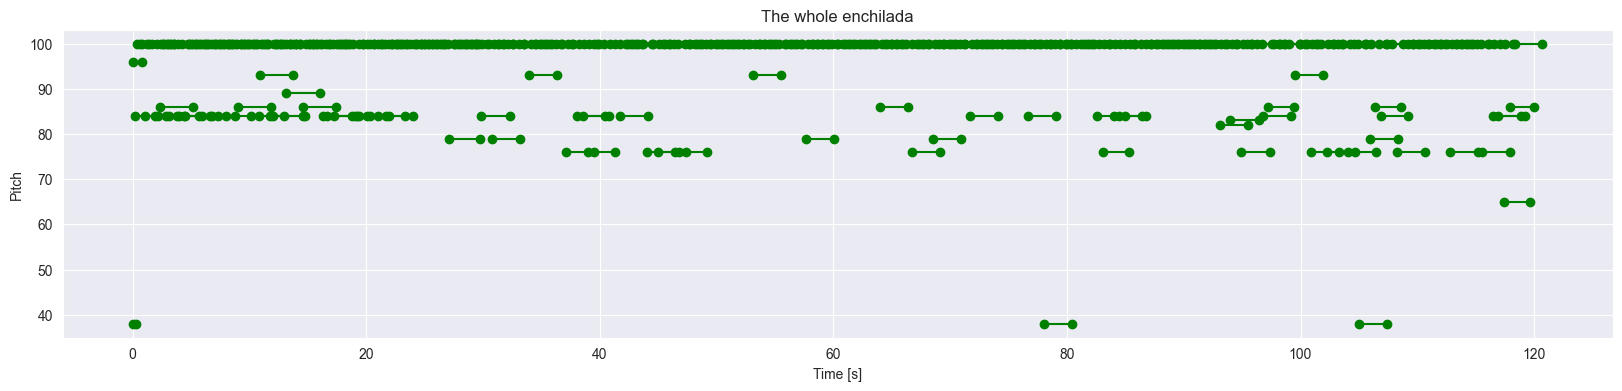

In [109]:
plot_track(generated_notes)

The generated music variables of `pitch`, `step` and `duration` distributions should be similar (but not necessarily identical, because the loss was not 0) to the training dataset.

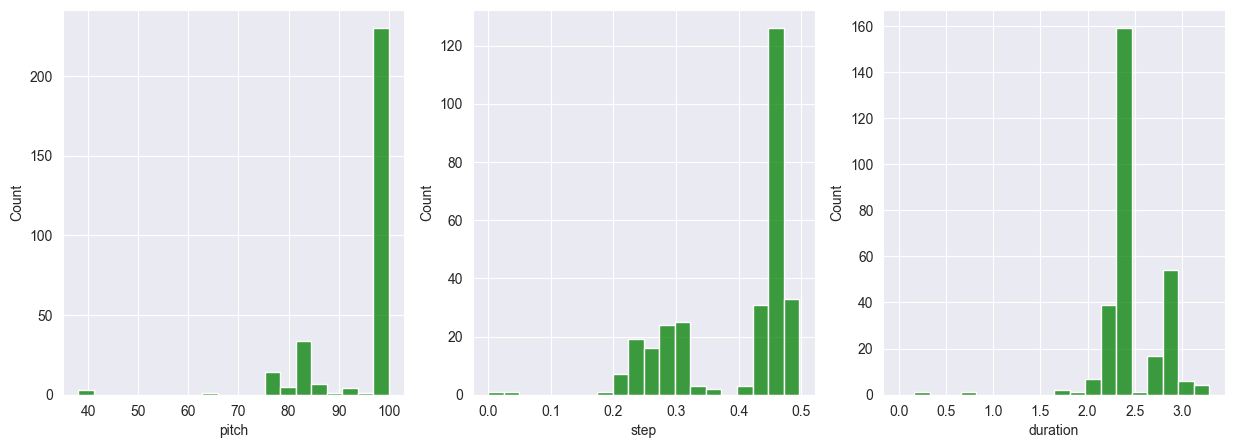

In [110]:
plot_distributions(generated_notes)

In the generated note distribution plots by pitch-step-duration, it is noticeable the slight change in distribution of the original note variables. Since there is a feedback loop between the model's outputs and inputs, the model tends to generate similar sequences of outputs to reduce the loss. This is particularly relevant for `step` and `duration`, which uses the MSE loss. For `pitch`, you can increase the randomness by increasing the `temperature` in `predict_next_note`.
